In [1]:
pip install pandas pyarrow


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pyarrow.feather as feather

# Read only necessary columns
table = feather.read_table('/content/drive/My Drive/ivs3.feather', columns=['datetime', 'vix'])
df = table.to_pandas()


In [3]:
import pandas as pd

# Ensure datetime is in correct format
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date  # for grouping

# STEP 3: Take 3 rows per day: start, middle, end
sampled_rows = []

for date, group in df.groupby('date'):
    if len(group) >= 3:
        group = group.sort_values('datetime')
        idx = [0, len(group)//2, -1]
        sampled_rows.append(group.iloc[idx])

df_sampled = pd.concat(sampled_rows).reset_index(drop=True)
df_sampled.drop(columns='date', inplace=True)

df_sampled.head()


,datetime,vix
0,2024-01-23 13:38:15,14.9075
1,2024-01-23 14:34:15,15.0050
2,2024-01-23 15:30:00,14.8775
3,2024-01-24 09:16:00,15.3575
4,2024-01-24 12:23:00,15.0050


In [4]:
# Save the reduced file to drive if needed
df_sampled.to_feather('/content/drive/My Drive/vix_3rows_per_day.feather')


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_sampled['vix_scaled'] = scaler.fit_transform(df_sampled[['vix']])


In [6]:
from sklearn.cluster import KMeans

# Clustering on scaled vix values
kmeans = KMeans(n_clusters=5, random_state=42)
df_sampled['cluster'] = kmeans.fit_predict(df_sampled[['vix_scaled']])


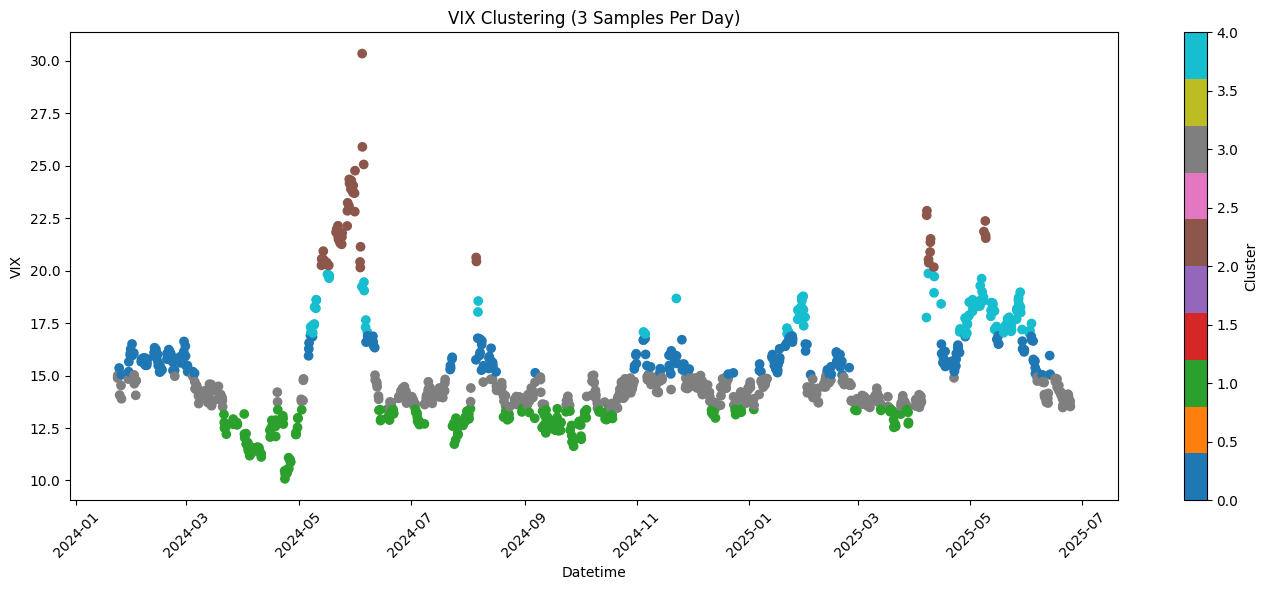

In [7]:
import matplotlib.pyplot as plt

# Sort by datetime
df_sampled = df_sampled.sort_values('datetime')

plt.figure(figsize=(14, 6))
scatter = plt.scatter(df_sampled['datetime'], df_sampled['vix'], c=df_sampled['cluster'], cmap='tab10')
plt.title('VIX Clustering (3 Samples Per Day)')
plt.xlabel('Datetime')
plt.ylabel('VIX')
plt.colorbar(scatter, label='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


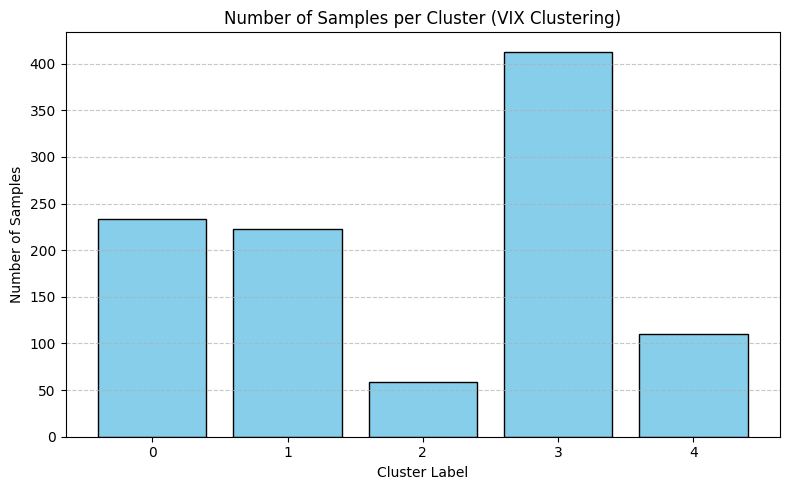

In [8]:
import matplotlib.pyplot as plt

# Count number of points in each cluster
cluster_counts = df_sampled['cluster'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Cluster (VIX Clustering)')
plt.xticks(cluster_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
